In [ ]:
# ================================
# Bluebikes Usage Prediction Notebook
# Predict usage_month_12 using months 1–11 + geographic features
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Display settings
pd.set_option("display.max_columns", 50)

print("Libraries loaded.")


In [ ]:
df = pd.read_csv("station_features_2024.csv")

print(df.shape)
df.head()

In [ ]:
import pandas as pd

df = pd.read_csv("station_features_2024.csv")

# 单独挑你要测试的特征
features = [
    "lat", 
    "lng",
    "num_attractions_r500",
    "dist_to_park",
    "dist_to_bikelane"
]

# 计算每个特征与 usage_total 的相关性
correlations = {}

for f in features:
    correlations[f] = df[f].corr(df["usage_total"])

correlations


In [ ]:
monthly_corr = {}

for f in features:
    monthly_corr[f] = []
    for m in range(1, 13):
        monthly_corr[f].append(df[f].corr(df[f"usage_month_{m}"]))

monthly_corr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = df[features + ["usage_total"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm")
plt.title("Correlation with usage_total")
plt.show()


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

df = pd.read_csv("station_features_2024.csv")

plt.style.use("seaborn-v0_8")


In [8]:
def plot_non_linear(df, feature, target="usage_total", frac=0.4):
    plt.figure(figsize=(7,5))

    # scatter
    plt.scatter(df[feature], df[target], alpha=0.6, label="Data", s=35)

    # LOWESS 平滑
    smoothed = lowess(df[target], df[feature], frac=frac)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=3, label="LOWESS")

    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"{feature} vs {target} (with LOWESS)")
    plt.legend()
    plt.grid(True)
    plt.show()


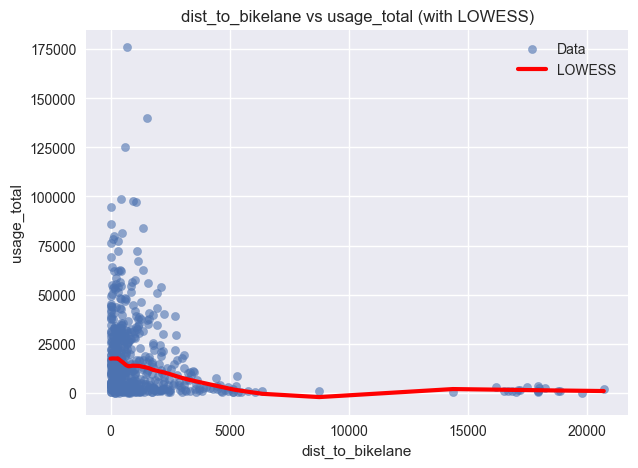

In [9]:
plot_non_linear(df, "dist_to_bikelane", "usage_total")

/Users/wuling/Desktop/25Fall/CS506/bluebikes-demand-forecast/venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


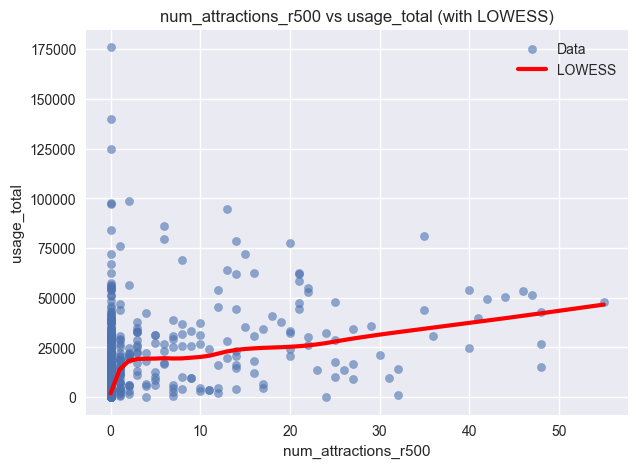

In [10]:
plot_non_linear(df, "num_attractions_r500", "usage_total")

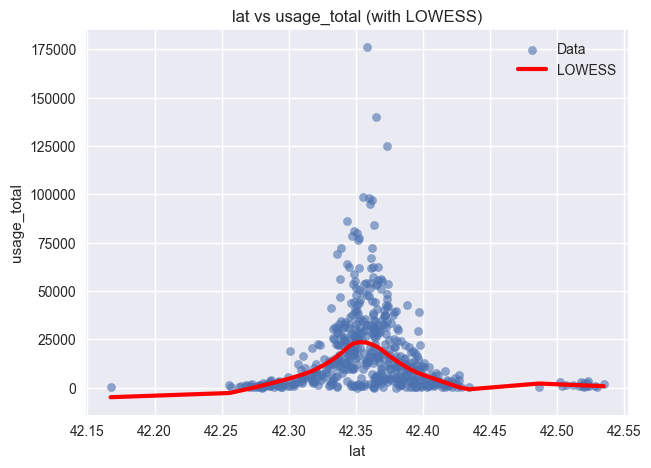

In [11]:
plot_non_linear(df, "lat", "usage_total")

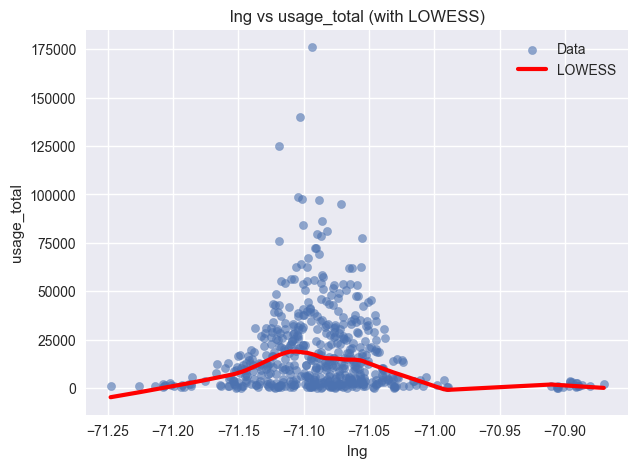

In [12]:
plot_non_linear(df, "lng", "usage_total")

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv("station_features_2024.csv")

# ---------------------------
# dist_to_bikelane transforms
# ---------------------------

df["log_dist_bikelane"] = np.log1p(df["dist_to_bikelane"])

df["inv_dist_bikelane"] = 1 / (df["dist_to_bikelane"] + 1)

df["dist_bikelane_clipped"] = df["dist_to_bikelane"].clip(0, 3000)

df["dist_bikelane_norm"] = (
    df["dist_to_bikelane"] - df["dist_to_bikelane"].mean()
) / df["dist_to_bikelane"].std()

df["dist_bikelane_bucket"] = pd.cut(
    df["dist_to_bikelane"],
    bins=[-1, 200, 800, 2000, 5000, np.inf],
    labels=["very_close", "close", "medium", "far", "very_far"]
)

bucket_map = {"very_close":4, "close":3, "medium":2, "far":1, "very_far":0}
df["dist_bikelane_bucket_num"] = df["dist_bikelane_bucket"].map(bucket_map)


# --------------------------------
# num_attractions_r500 transforms
# --------------------------------

df["log_attractions"] = np.log1p(df["num_attractions_r500"])
df["sqrt_attractions"] = np.sqrt(df["num_attractions_r500"])

df["attractions_bucket"] = pd.cut(
    df["num_attractions_r500"],
    bins=[-1, 0, 3, 10, np.inf],
    labels=["none", "few", "medium", "many"]
)

print(df.head())


  station_id                                 station_name        lat  \
0     A32000                                     Fan Pier  42.353391   
1     A32001  Union Square - Brighton Ave at Cambridge St  42.353334   
2     A32002              Commonwealth Ave at Agganis Way  42.351692   
3     A32003                B.U. Central - 725 Comm. Ave.  42.350385   
4     A32004                    Longwood Ave at Binney St  42.338466   

         lng  usage_total  usage_month_1  usage_month_2  usage_month_3  \
0 -71.044571        20300          625.0          778.0         1087.0   
1 -71.137313        31080         1131.0         1630.0         2073.0   
2 -71.119035        76191         2732.0         4586.0         4695.0   
3 -71.108131        33055         1003.0         1801.0         2038.0   
4 -71.106984        56382         1443.0         1870.0         2138.0   

   usage_month_4  usage_month_5  ...  dist_to_bikelane  log_dist_bikelane  \
0         1286.0         2140.0  ...        1